In [3]:
import sys
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import argparse
import matplotlib.pyplot as plt
from networks import *
from normal_train import *
import numpy as np
import copy
import math

In [38]:
%matplotlib inline
import sys
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import argparse
import matplotlib.pyplot as plt
from networks import *
from normal_train import *
import numpy as np
import copy
import math

def sum_of_all_parameter(model):
    res = 0
    if isinstance(model, TwoLayerReluASI):
        for p in model.features1:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())

        for p in model.features2:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())
    else:
        for p in model.features:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())

    return res

def two_relu_layer_train(args, num_neurons=100):
    epochs = 100000
    path = '/home/huijin/seminar project/model/'

    #     tag='sgd_epoch'+str(epochs)+'_init_'+str(initialization)+'_lr_'+str(learning_rate)+'_bs_'+str(batch_size)+'_network_'+network_choice
    tag = args['tag']+str(num_neurons)
    input_dim = args['input_dim']
    
    model = TwoLayerReluASI(input_dim=input_dim, num_neurons=num_neurons, 
                            initialization=args['weight'], bias_tune_tuple=args['bias'])

    global best_acc
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    use_cuda = True
    best_loss = 1000000
    old_loss = 10
    learning_rate = 0.05 #0.02
    #     momentum = 0.9
    #     weight_decay = 5e-4
    # Data
    #     dataloader = datasets.CIFAR10
    #     train_batch = batch_size #128
    #     test_batch = 100
    workers = 1
    decay_epoch = 100000
    use_cuda = False

    #     if accumulation_steps*batch_size/learning_rate>=4096/0.02:
    #         decay_epoch = 250
    #         epochs = 400
    #     elif accumulation_steps*batch_size/learning_rate>=4096/0.04:
    #         decay_epoch = 200
    #         epochs = 350

#     xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
#     fp = [1.5, 0.5, 1.5, 0.5, 1.5]
    xp = args['xp']
    fp = args['fp']
    # train_input = np.sort(np.concatenate((np.random.uniform(-2,2,30),xp))).astype(np.float32)
#     train_input = np.sort(xp).astype(np.float32)
#     train_output = np.interp(train_input, xp, fp).astype(np.float32)
    train_input = xp
    train_output = fp

    trainset = [(train_input[i:i+1], train_output[i:i+1]) for i in range(train_input.shape[0])]
    # batch_size=train_input.shape[0]
    trainloader = data.DataLoader(trainset, batch_size=train_input.shape[0], shuffle=False, num_workers=workers)

    #     testset = dataloader(root='/home/huijin/large-batch-training-torch/data', train=False, download=False, transform=transform_test)
    #     testloader = data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=workers)

    #     model = AlexNet(10)
    #     model_state = torch.load('model_38')
    #     model.load_state_dict(model_state)

    criterion = nn.MSELoss()
    #     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay= weight_decay)
    if args['train_only_output']:
        model.features1[0].weight.requires_grad = False
        model.features1[0].bias.requires_grad = False
        model.features2[0].weight.requires_grad = False
        model.features2[0].bias.requires_grad = False

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    if use_cuda == True:
        model = model.cuda()
        criterion = criterion.cuda()

    # Initialization

    #     initial_model_file = '/home/huijin/large-batch-training-torch/model/init_'+str(initialization)+'_network_'+network_choice
    #     if os.path.isfile(initial_model_file):
    #         model_state = torch.load(initial_model_file)
    #         model.load_state_dict(model_state)
    #     else:
    #         torch.save(model.state_dict(), initial_model_file)
    inital_norm_weight = sum_of_all_parameter(model)
    # Train and val
    history = dict(loss=list(),val_loss=list(),acc=list(),val_acc=list())
    old_loss = test(trainloader, model, criterion, 0, use_cuda)+0.01
    for epoch in range(start_epoch, epochs):
#         import ipdb; ipdb.set_trace() 
        old_state_dict = copy.deepcopy(model.state_dict())
#         print(old_state_dict)
#         import ipdb; ipdb.set_trace()
        train_loss = train(trainloader, model, criterion, optimizer, epoch, use_cuda)
    #         test_loss, test_acc = test(testloader, model, criterion, epoch, use_cuda)
        train_loss = test(trainloader, model, criterion, epoch, use_cuda)
        print('Epoch: [%d | %d] LR: %f; Train Loss %f'
              % (epoch + 1, epochs, optimizer.param_groups[0]['lr'],train_loss))
        sys.stdout.flush()
        history['loss'].append(train_loss)

        # save model
        is_best = train_loss < best_loss
        best_loss = min(train_loss, best_loss)
        if is_best:
            torch.save(model.state_dict(), path+tag+'_best'+"normal [-1,1]")
        # torch.save(model.state_dict(), '/home/huijin/large-batch-training-torch/model/'+tag+'model_batch_'+str(epoch+1))

        if train_loss > old_loss:
            model.load_state_dict(old_state_dict)
            learning_rate = learning_rate*0.5
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] *= 1.0/2
        else:
            if epoch % decay_epoch == (decay_epoch-1):
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.5
            if abs(old_loss-train_loss)<1e-8:
                break
            old_loss = train_loss

    torch.save(model.state_dict(), path+tag)
    
    end_norm_weight = sum_of_all_parameter(model)
    
#     test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
#     testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
#     testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=workers)
#     for batch_idx, inputs in enumerate(testloader):
#         outputs = model(inputs)
#     test_output = outputs.squeeze().detach().numpy()
#     true_output = np.interp(test_input, xp, fp)
#     away_from_piecewise_linear = np.mean((true_output-test_output)**2)
    return (inital_norm_weight, end_norm_weight, 0, train_loss, model)

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.square_sum = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.square_sum += val * val * n
        self.count += n
        self.avg = self.sum / self.count
        self.std = self.square_sum / self.count - self.avg*self.avg

args = dict()
args['xp'] = np.array([[-1,-1], [1,1], [0,0], [-1,1], [1,-1]],dtype=np.float32)
# args['xp'] = np.array([[-1.3,-0.7], [0.5,0.9], [-0.8,0.3], [-0.4,1.6], [1.6,-0.4]],dtype=np.float32)
args['fp'] = np.array([[1.5], [1.5], [0.5], [-0.5], [-0.5]],dtype=np.float32)
# args['fp'] = np.array([1.5, 1.5, 0.5, -0.5, -0.5],dtype=np.float32)
# args['fp'] = np.array([[0.05], [0.02], [0], [-0.01], [-0.03]],dtype=np.float32)
args['input_dim'] = 2
args['tag'] = "2d_toy"
args['train_only_output'] = True
# args['bias'] = ("uniform", 2)
args['bias'] = ("uniform", 2)
args['weight'] = "unit_vector"

numgrid = 21
R = np.abs(args['xp']).max()
x = np.linspace(-R, R, numgrid, dtype=np.float32)
h = x[1]-x[0]
y = np.linspace(-R, R, numgrid, dtype=np.float32)
X, Y = np.meshgrid(x, y)
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=2)

M = args['xp'].shape[0]
d = args['xp'].shape[1]
coeff = np.zeros((M+d+1,M+d+1))
for i in range(M):
    coeff[i,0:M] = np.linalg.norm(args['xp']-args['xp'][i], axis=1)**3
    coeff[i,M:M+d] = args['xp'][i]
    coeff[i,M+d] = 1
    coeff[M:M+d, i] = args['xp'][i]
    coeff[M+d, i] = 1

lambda_u_v = np.linalg.solve(coeff, np.concatenate((args['fp'].squeeze(),np.zeros(3))))

u_first = lambda_u_v[-3:-1]
v_first = lambda_u_v[-1]

fx = x.copy()
fy = y.copy()
f_variation_exact = np.zeros((fx.shape[0], fy.shape[0]))
fX, fY = np.meshgrid(fx, fy)
xi = np.zeros((2))

print("compute f")
for idx, ix in enumerate(fx):
    for idy, iy in enumerate(fy):
        xi[0] = ix
        xi[1] = iy
        f_variation_exact[idy,idx]=np.dot(lambda_u_v, 
                                          np.concatenate((np.linalg.norm(args['xp']-xi, axis=1)**3,xi,np.ones(1))))
        
# nums_of_neurons=[10,20,40,80,160,320,640,1280,2560]
nums_of_neurons=[20]

inital_norm_weight_vs_num = []
inital_norm_weight_std_vs_num = []
end_norm_weight_vs_num = []
end_norm_weight_std_vs_num = []
away_from_variational_vs_num = []
away_from_variational_std_vs_num = []
train_loss_vs_num = []
train_loss_std_vs_num = []

for num_of_neurons in nums_of_neurons:
    number_of_try = 3
    inital_norm_weights = AverageMeter()
    end_norm_weights = AverageMeter()
    away_from_variationals = AverageMeter()
    train_losses = AverageMeter()
    for init in range(number_of_try):
        inital_norm_weight, end_norm_weight, away_from_variational, train_loss, model = two_relu_layer_train(args, num_of_neurons)
        test_input = np.concatenate((X, Y), axis=2)
        test_input = test_input.reshape(-1,2)
        testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
        testloader = data.DataLoader(testset, batch_size=numgrid*numgrid, shuffle=False, num_workers=1)
        for batch_idx, inputs in enumerate(testloader):
            outputs = model(inputs)
        test_output = outputs.squeeze().detach().numpy()
        test_output = test_output.reshape(numgrid, numgrid)
        away_from_variational = np.sum((test_output - f_variation_exact)**2)*h*h
        inital_norm_weights.update(inital_norm_weight)
        end_norm_weights.update(end_norm_weight)
        away_from_variationals.update(away_from_variational)
        train_losses.update(train_loss)

    inital_norm_weight_vs_num.append(inital_norm_weights.avg)
    end_norm_weight_vs_num.append(end_norm_weights.avg)
    away_from_variational_vs_num.append(away_from_variationals.avg)

    inital_norm_weight_std_vs_num.append(inital_norm_weights.std)
    end_norm_weight_std_vs_num.append(end_norm_weights.std)
    away_from_variational_std_vs_num.append(away_from_variationals.std)

    train_loss_vs_num.append(train_losses.avg)
    train_loss_std_vs_num.append(train_losses.std)

print(inital_norm_weight_vs_num)
print(end_norm_weight_vs_num)
print(away_from_variational_vs_num)
print(train_loss_vs_num)

print(inital_norm_weight_std_vs_num)
print(end_norm_weight_std_vs_num)
print(away_from_variational_std_vs_num)
print(train_loss_std_vs_num)


compute f
Epoch: [1 | 100000] LR: 0.050000; Train Loss 0.766345
Epoch: [2 | 100000] LR: 0.050000; Train Loss 0.693838
Epoch: [3 | 100000] LR: 0.050000; Train Loss 0.636202
Epoch: [4 | 100000] LR: 0.050000; Train Loss 0.585988
Epoch: [5 | 100000] LR: 0.050000; Train Loss 0.541726
Epoch: [6 | 100000] LR: 0.050000; Train Loss 0.502414
Epoch: [7 | 100000] LR: 0.050000; Train Loss 0.467272
Epoch: [8 | 100000] LR: 0.050000; Train Loss 0.435681
Epoch: [9 | 100000] LR: 0.050000; Train Loss 0.407138
Epoch: [10 | 100000] LR: 0.050000; Train Loss 0.381234
Epoch: [11 | 100000] LR: 0.050000; Train Loss 0.357633
Epoch: [12 | 100000] LR: 0.050000; Train Loss 0.336053
Epoch: [13 | 100000] LR: 0.050000; Train Loss 0.316258
Epoch: [14 | 100000] LR: 0.050000; Train Loss 0.298050
Epoch: [15 | 100000] LR: 0.050000; Train Loss 0.281260
Epoch: [16 | 100000] LR: 0.050000; Train Loss 0.265742
Epoch: [17 | 100000] LR: 0.050000; Train Loss 0.251372
Epoch: [18 | 100000] LR: 0.050000; Train Loss 0.238042
Epoch: [1

Epoch: [150 | 100000] LR: 0.050000; Train Loss 0.019437
Epoch: [151 | 100000] LR: 0.050000; Train Loss 0.019262
Epoch: [152 | 100000] LR: 0.050000; Train Loss 0.019089
Epoch: [153 | 100000] LR: 0.050000; Train Loss 0.018917
Epoch: [154 | 100000] LR: 0.050000; Train Loss 0.018747
Epoch: [155 | 100000] LR: 0.050000; Train Loss 0.018579
Epoch: [156 | 100000] LR: 0.050000; Train Loss 0.018412
Epoch: [157 | 100000] LR: 0.050000; Train Loss 0.018247
Epoch: [158 | 100000] LR: 0.050000; Train Loss 0.018083
Epoch: [159 | 100000] LR: 0.050000; Train Loss 0.017921
Epoch: [160 | 100000] LR: 0.050000; Train Loss 0.017761
Epoch: [161 | 100000] LR: 0.050000; Train Loss 0.017601
Epoch: [162 | 100000] LR: 0.050000; Train Loss 0.017444
Epoch: [163 | 100000] LR: 0.050000; Train Loss 0.017288
Epoch: [164 | 100000] LR: 0.050000; Train Loss 0.017133
Epoch: [165 | 100000] LR: 0.050000; Train Loss 0.016979
Epoch: [166 | 100000] LR: 0.050000; Train Loss 0.016827
Epoch: [167 | 100000] LR: 0.050000; Train Loss 0

Epoch: [297 | 100000] LR: 0.050000; Train Loss 0.005198
Epoch: [298 | 100000] LR: 0.050000; Train Loss 0.005152
Epoch: [299 | 100000] LR: 0.050000; Train Loss 0.005106
Epoch: [300 | 100000] LR: 0.050000; Train Loss 0.005060
Epoch: [301 | 100000] LR: 0.050000; Train Loss 0.005015
Epoch: [302 | 100000] LR: 0.050000; Train Loss 0.004970
Epoch: [303 | 100000] LR: 0.050000; Train Loss 0.004926
Epoch: [304 | 100000] LR: 0.050000; Train Loss 0.004882
Epoch: [305 | 100000] LR: 0.050000; Train Loss 0.004838
Epoch: [306 | 100000] LR: 0.050000; Train Loss 0.004795
Epoch: [307 | 100000] LR: 0.050000; Train Loss 0.004752
Epoch: [308 | 100000] LR: 0.050000; Train Loss 0.004710
Epoch: [309 | 100000] LR: 0.050000; Train Loss 0.004668
Epoch: [310 | 100000] LR: 0.050000; Train Loss 0.004626
Epoch: [311 | 100000] LR: 0.050000; Train Loss 0.004585
Epoch: [312 | 100000] LR: 0.050000; Train Loss 0.004544
Epoch: [313 | 100000] LR: 0.050000; Train Loss 0.004503
Epoch: [314 | 100000] LR: 0.050000; Train Loss 0

Epoch: [444 | 100000] LR: 0.050000; Train Loss 0.001392
Epoch: [445 | 100000] LR: 0.050000; Train Loss 0.001379
Epoch: [446 | 100000] LR: 0.050000; Train Loss 0.001367
Epoch: [447 | 100000] LR: 0.050000; Train Loss 0.001355
Epoch: [448 | 100000] LR: 0.050000; Train Loss 0.001343
Epoch: [449 | 100000] LR: 0.050000; Train Loss 0.001331
Epoch: [450 | 100000] LR: 0.050000; Train Loss 0.001319
Epoch: [451 | 100000] LR: 0.050000; Train Loss 0.001307
Epoch: [452 | 100000] LR: 0.050000; Train Loss 0.001295
Epoch: [453 | 100000] LR: 0.050000; Train Loss 0.001284
Epoch: [454 | 100000] LR: 0.050000; Train Loss 0.001272
Epoch: [455 | 100000] LR: 0.050000; Train Loss 0.001261
Epoch: [456 | 100000] LR: 0.050000; Train Loss 0.001250
Epoch: [457 | 100000] LR: 0.050000; Train Loss 0.001239
Epoch: [458 | 100000] LR: 0.050000; Train Loss 0.001228
Epoch: [459 | 100000] LR: 0.050000; Train Loss 0.001217
Epoch: [460 | 100000] LR: 0.050000; Train Loss 0.001206
Epoch: [461 | 100000] LR: 0.050000; Train Loss 0

Epoch: [591 | 100000] LR: 0.050000; Train Loss 0.000373
Epoch: [592 | 100000] LR: 0.050000; Train Loss 0.000369
Epoch: [593 | 100000] LR: 0.050000; Train Loss 0.000366
Epoch: [594 | 100000] LR: 0.050000; Train Loss 0.000363
Epoch: [595 | 100000] LR: 0.050000; Train Loss 0.000360
Epoch: [596 | 100000] LR: 0.050000; Train Loss 0.000356
Epoch: [597 | 100000] LR: 0.050000; Train Loss 0.000353
Epoch: [598 | 100000] LR: 0.050000; Train Loss 0.000350
Epoch: [599 | 100000] LR: 0.050000; Train Loss 0.000347
Epoch: [600 | 100000] LR: 0.050000; Train Loss 0.000344
Epoch: [601 | 100000] LR: 0.050000; Train Loss 0.000341
Epoch: [602 | 100000] LR: 0.050000; Train Loss 0.000338
Epoch: [603 | 100000] LR: 0.050000; Train Loss 0.000335
Epoch: [604 | 100000] LR: 0.050000; Train Loss 0.000332
Epoch: [605 | 100000] LR: 0.050000; Train Loss 0.000329
Epoch: [606 | 100000] LR: 0.050000; Train Loss 0.000326
Epoch: [607 | 100000] LR: 0.050000; Train Loss 0.000323
Epoch: [608 | 100000] LR: 0.050000; Train Loss 0

Epoch: [738 | 100000] LR: 0.050000; Train Loss 0.000100
Epoch: [739 | 100000] LR: 0.050000; Train Loss 0.000099
Epoch: [740 | 100000] LR: 0.050000; Train Loss 0.000098
Epoch: [741 | 100000] LR: 0.050000; Train Loss 0.000097
Epoch: [742 | 100000] LR: 0.050000; Train Loss 0.000096
Epoch: [743 | 100000] LR: 0.050000; Train Loss 0.000095
Epoch: [744 | 100000] LR: 0.050000; Train Loss 0.000095
Epoch: [745 | 100000] LR: 0.050000; Train Loss 0.000094
Epoch: [746 | 100000] LR: 0.050000; Train Loss 0.000093
Epoch: [747 | 100000] LR: 0.050000; Train Loss 0.000092
Epoch: [748 | 100000] LR: 0.050000; Train Loss 0.000091
Epoch: [749 | 100000] LR: 0.050000; Train Loss 0.000090
Epoch: [750 | 100000] LR: 0.050000; Train Loss 0.000090
Epoch: [751 | 100000] LR: 0.050000; Train Loss 0.000089
Epoch: [752 | 100000] LR: 0.050000; Train Loss 0.000088
Epoch: [753 | 100000] LR: 0.050000; Train Loss 0.000087
Epoch: [754 | 100000] LR: 0.050000; Train Loss 0.000086
Epoch: [755 | 100000] LR: 0.050000; Train Loss 0

Epoch: [885 | 100000] LR: 0.050000; Train Loss 0.000027
Epoch: [886 | 100000] LR: 0.050000; Train Loss 0.000026
Epoch: [887 | 100000] LR: 0.050000; Train Loss 0.000026
Epoch: [888 | 100000] LR: 0.050000; Train Loss 0.000026
Epoch: [889 | 100000] LR: 0.050000; Train Loss 0.000026
Epoch: [890 | 100000] LR: 0.050000; Train Loss 0.000026
Epoch: [891 | 100000] LR: 0.050000; Train Loss 0.000025
Epoch: [892 | 100000] LR: 0.050000; Train Loss 0.000025
Epoch: [893 | 100000] LR: 0.050000; Train Loss 0.000025
Epoch: [894 | 100000] LR: 0.050000; Train Loss 0.000025
Epoch: [895 | 100000] LR: 0.050000; Train Loss 0.000024
Epoch: [896 | 100000] LR: 0.050000; Train Loss 0.000024
Epoch: [897 | 100000] LR: 0.050000; Train Loss 0.000024
Epoch: [898 | 100000] LR: 0.050000; Train Loss 0.000024
Epoch: [899 | 100000] LR: 0.050000; Train Loss 0.000024
Epoch: [900 | 100000] LR: 0.050000; Train Loss 0.000023
Epoch: [901 | 100000] LR: 0.050000; Train Loss 0.000023
Epoch: [902 | 100000] LR: 0.050000; Train Loss 0

Epoch: [1031 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1032 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1033 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1034 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1035 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1036 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1037 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1038 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1039 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1040 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1041 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1042 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [1043 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [1044 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [1045 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [1046 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [1047 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [1048 | 100000] LR: 0.05

Epoch: [1175 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1176 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1177 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1178 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1179 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1180 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1181 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1182 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1183 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1184 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1185 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1186 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1187 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1188 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1189 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1190 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1191 | 100000] LR: 0.050000; Train Loss 0.000002
Epoch: [1192 | 100000] LR: 0.05

Epoch: [83 | 100000] LR: 0.050000; Train Loss 0.046974
Epoch: [84 | 100000] LR: 0.050000; Train Loss 0.045450
Epoch: [85 | 100000] LR: 0.050000; Train Loss 0.043976
Epoch: [86 | 100000] LR: 0.050000; Train Loss 0.042552
Epoch: [87 | 100000] LR: 0.050000; Train Loss 0.041174
Epoch: [88 | 100000] LR: 0.050000; Train Loss 0.039843
Epoch: [89 | 100000] LR: 0.050000; Train Loss 0.038555
Epoch: [90 | 100000] LR: 0.050000; Train Loss 0.037310
Epoch: [91 | 100000] LR: 0.050000; Train Loss 0.036107
Epoch: [92 | 100000] LR: 0.050000; Train Loss 0.034943
Epoch: [93 | 100000] LR: 0.050000; Train Loss 0.033818
Epoch: [94 | 100000] LR: 0.050000; Train Loss 0.032730
Epoch: [95 | 100000] LR: 0.050000; Train Loss 0.031678
Epoch: [96 | 100000] LR: 0.050000; Train Loss 0.030661
Epoch: [97 | 100000] LR: 0.050000; Train Loss 0.029678
Epoch: [98 | 100000] LR: 0.050000; Train Loss 0.028727
Epoch: [99 | 100000] LR: 0.050000; Train Loss 0.027807
Epoch: [100 | 100000] LR: 0.050000; Train Loss 0.026918
Epoch: [1

Epoch: [230 | 100000] LR: 0.050000; Train Loss 0.000673
Epoch: [231 | 100000] LR: 0.050000; Train Loss 0.000658
Epoch: [232 | 100000] LR: 0.050000; Train Loss 0.000644
Epoch: [233 | 100000] LR: 0.050000; Train Loss 0.000629
Epoch: [234 | 100000] LR: 0.050000; Train Loss 0.000615
Epoch: [235 | 100000] LR: 0.050000; Train Loss 0.000602
Epoch: [236 | 100000] LR: 0.050000; Train Loss 0.000589
Epoch: [237 | 100000] LR: 0.050000; Train Loss 0.000576
Epoch: [238 | 100000] LR: 0.050000; Train Loss 0.000563
Epoch: [239 | 100000] LR: 0.050000; Train Loss 0.000551
Epoch: [240 | 100000] LR: 0.050000; Train Loss 0.000539
Epoch: [241 | 100000] LR: 0.050000; Train Loss 0.000528
Epoch: [242 | 100000] LR: 0.050000; Train Loss 0.000516
Epoch: [243 | 100000] LR: 0.050000; Train Loss 0.000505
Epoch: [244 | 100000] LR: 0.050000; Train Loss 0.000495
Epoch: [245 | 100000] LR: 0.050000; Train Loss 0.000484
Epoch: [246 | 100000] LR: 0.050000; Train Loss 0.000474
Epoch: [247 | 100000] LR: 0.050000; Train Loss 0

Epoch: [377 | 100000] LR: 0.050000; Train Loss 0.000049
Epoch: [378 | 100000] LR: 0.050000; Train Loss 0.000048
Epoch: [379 | 100000] LR: 0.050000; Train Loss 0.000047
Epoch: [380 | 100000] LR: 0.050000; Train Loss 0.000047
Epoch: [381 | 100000] LR: 0.050000; Train Loss 0.000046
Epoch: [382 | 100000] LR: 0.050000; Train Loss 0.000045
Epoch: [383 | 100000] LR: 0.050000; Train Loss 0.000045
Epoch: [384 | 100000] LR: 0.050000; Train Loss 0.000044
Epoch: [385 | 100000] LR: 0.050000; Train Loss 0.000043
Epoch: [386 | 100000] LR: 0.050000; Train Loss 0.000043
Epoch: [387 | 100000] LR: 0.050000; Train Loss 0.000042
Epoch: [388 | 100000] LR: 0.050000; Train Loss 0.000041
Epoch: [389 | 100000] LR: 0.050000; Train Loss 0.000041
Epoch: [390 | 100000] LR: 0.050000; Train Loss 0.000040
Epoch: [391 | 100000] LR: 0.050000; Train Loss 0.000039
Epoch: [392 | 100000] LR: 0.050000; Train Loss 0.000039
Epoch: [393 | 100000] LR: 0.050000; Train Loss 0.000038
Epoch: [394 | 100000] LR: 0.050000; Train Loss 0

Epoch: [524 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [525 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [526 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [527 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [528 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [529 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [530 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [531 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [532 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [533 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [534 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [535 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [536 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [537 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [538 | 100000] LR: 0.050000; Train Loss 0.000005
Epoch: [539 | 100000] LR: 0.050000; Train Loss 0.000004
Epoch: [540 | 100000] LR: 0.050000; Train Loss 0.000004
Epoch: [541 | 100000] LR: 0.050000; Train Loss 0

Epoch: [2 | 100000] LR: 0.050000; Train Loss 0.821509
Epoch: [3 | 100000] LR: 0.050000; Train Loss 0.757061
Epoch: [4 | 100000] LR: 0.050000; Train Loss 0.708700
Epoch: [5 | 100000] LR: 0.050000; Train Loss 0.670178
Epoch: [6 | 100000] LR: 0.050000; Train Loss 0.637825
Epoch: [7 | 100000] LR: 0.050000; Train Loss 0.609475
Epoch: [8 | 100000] LR: 0.050000; Train Loss 0.583836
Epoch: [9 | 100000] LR: 0.050000; Train Loss 0.560139
Epoch: [10 | 100000] LR: 0.050000; Train Loss 0.537914
Epoch: [11 | 100000] LR: 0.050000; Train Loss 0.516874
Epoch: [12 | 100000] LR: 0.050000; Train Loss 0.496836
Epoch: [13 | 100000] LR: 0.050000; Train Loss 0.477682
Epoch: [14 | 100000] LR: 0.050000; Train Loss 0.459330
Epoch: [15 | 100000] LR: 0.050000; Train Loss 0.441720
Epoch: [16 | 100000] LR: 0.050000; Train Loss 0.424809
Epoch: [17 | 100000] LR: 0.050000; Train Loss 0.408559
Epoch: [18 | 100000] LR: 0.050000; Train Loss 0.392938
Epoch: [19 | 100000] LR: 0.050000; Train Loss 0.377920
Epoch: [20 | 10000

Epoch: [151 | 100000] LR: 0.050000; Train Loss 0.002260
Epoch: [152 | 100000] LR: 0.050000; Train Loss 0.002175
Epoch: [153 | 100000] LR: 0.050000; Train Loss 0.002093
Epoch: [154 | 100000] LR: 0.050000; Train Loss 0.002014
Epoch: [155 | 100000] LR: 0.050000; Train Loss 0.001938
Epoch: [156 | 100000] LR: 0.050000; Train Loss 0.001865
Epoch: [157 | 100000] LR: 0.050000; Train Loss 0.001795
Epoch: [158 | 100000] LR: 0.050000; Train Loss 0.001727
Epoch: [159 | 100000] LR: 0.050000; Train Loss 0.001662
Epoch: [160 | 100000] LR: 0.050000; Train Loss 0.001600
Epoch: [161 | 100000] LR: 0.050000; Train Loss 0.001539
Epoch: [162 | 100000] LR: 0.050000; Train Loss 0.001482
Epoch: [163 | 100000] LR: 0.050000; Train Loss 0.001426
Epoch: [164 | 100000] LR: 0.050000; Train Loss 0.001372
Epoch: [165 | 100000] LR: 0.050000; Train Loss 0.001321
Epoch: [166 | 100000] LR: 0.050000; Train Loss 0.001271
Epoch: [167 | 100000] LR: 0.050000; Train Loss 0.001223
Epoch: [168 | 100000] LR: 0.050000; Train Loss 0

Epoch: [298 | 100000] LR: 0.050000; Train Loss 0.000010
Epoch: [299 | 100000] LR: 0.050000; Train Loss 0.000010
Epoch: [300 | 100000] LR: 0.050000; Train Loss 0.000010
Epoch: [301 | 100000] LR: 0.050000; Train Loss 0.000009
Epoch: [302 | 100000] LR: 0.050000; Train Loss 0.000009
Epoch: [303 | 100000] LR: 0.050000; Train Loss 0.000009
Epoch: [304 | 100000] LR: 0.050000; Train Loss 0.000008
Epoch: [305 | 100000] LR: 0.050000; Train Loss 0.000008
Epoch: [306 | 100000] LR: 0.050000; Train Loss 0.000008
Epoch: [307 | 100000] LR: 0.050000; Train Loss 0.000008
Epoch: [308 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [309 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [310 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [311 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [312 | 100000] LR: 0.050000; Train Loss 0.000007
Epoch: [313 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [314 | 100000] LR: 0.050000; Train Loss 0.000006
Epoch: [315 | 100000] LR: 0.050000; Train Loss 0

<IPython.core.display.Javascript object>


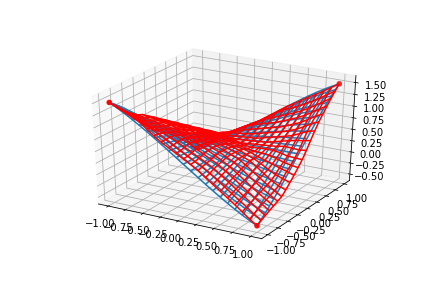

In [37]:
fx = x.copy()
fy = y.copy()
fX, fY = np.meshgrid(fx, fy)
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)
# ax.plot_wireframe(fX[120:-120,120:-120], fY[120:-120,120:-120], f[120:-120,120:-120])
ax.plot_wireframe(fX, fY, f_variation_exact)
ax.plot_wireframe(fX, fY, test_output, color="red")
ax.scatter3D(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), args['fp'].squeeze(), c="red");
plt.show()

In [8]:
v_first

0.5000000000000006

In [28]:
h

NameError: name 'h' is not defined

In [24]:
args['fp']

array([[ 1.5],
       [ 1.5],
       [ 0.5],
       [-0.5],
       [-0.5]], dtype=float32)

In [25]:
coeff

array([[ 0.        , 22.62741661,  2.82842708,  8.        ,  8.        ,
        -1.        , -1.        ,  1.        ],
       [22.62741661,  0.        ,  2.82842708,  8.        ,  8.        ,
         1.        ,  1.        ,  1.        ],
       [ 2.82842708,  2.82842708,  0.        ,  2.82842708,  2.82842708,
         0.        ,  0.        ,  1.        ],
       [ 8.        ,  8.        ,  2.82842708,  0.        , 22.62741661,
        -1.        ,  1.        ,  1.        ],
       [ 8.        ,  8.        ,  2.82842708, 22.62741661,  0.        ,
         1.        , -1.        ,  1.        ],
       [-1.        ,  1.        ,  0.        , -1.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  1.        , -1.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ]])

In [30]:
test_output

array([[ 1.4993843 ,  1.4296261 ,  1.3598682 ,  1.29011   ,  1.2181034 ,
         1.1011846 ,  0.9806726 ,  0.8771474 ,  0.7891486 ,  0.7008953 ,
         0.612642  ,  0.52438897,  0.42931232,  0.30899915,  0.1955027 ,
         0.08200632, -0.0314901 , -0.14672977, -0.26720443, -0.38904822,
        -0.5000567 ],
       [ 1.3990731 ,  1.3293152 ,  1.259557  ,  1.1897991 ,  1.1200409 ,
         1.0502827 ,  0.9667556 ,  0.8791702 ,  0.7913327 ,  0.70307964,
         0.6181762 ,  0.53679   ,  0.45540342,  0.3499578 ,  0.23646154,
         0.12296496,  0.0094685 , -0.1040279 , -0.2163921 , -0.33625323,
        -0.44617185],
       [ 1.2987621 ,  1.2290043 ,  1.1592461 ,  1.0894879 ,  1.0197297 ,
         0.9748584 ,  0.9380272 ,  0.880329  ,  0.80703396,  0.72564745,
         0.644261  ,  0.5628746 ,  0.4814881 ,  0.39091656,  0.27742004,
         0.16392368,  0.05042723, -0.06306928, -0.17551349, -0.28673118,
        -0.3925927 ],
       [ 1.1984512 ,  1.128693  ,  1.058935  ,  0.99226034

In [31]:
away_from_variational

0.07440611593205382

In [39]:
print(inital_norm_weight_vs_num)
print(end_norm_weight_vs_num)
print(away_from_variational_vs_num)
print(train_loss_vs_num)

print(inital_norm_weight_std_vs_num)
print(end_norm_weight_std_vs_num)
print(away_from_variational_std_vs_num)
print(train_loss_std_vs_num)

[10.035991311073303]
[11.99566920598348]
[0.11623751601980176]
[tensor(7.3140e-07)]
[0.0032308376644749615]
[0.032782274034843795]
[0.0004928009381381451]
[tensor(8.8618e-14)]


In [77]:
#Gaussian
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560,5120]
y=np.array([0.5087838423008789, 0.17029626008666274, 0.11172634983483315, 0.03779847070468886, 0.016310560803574816, 0.007502495089343165, 0.0024358773018068407, 0.003040371520103424, 0.0009556105733299966, 0.0003391049195038465])
error=np.array([0.08970238246198681, 0.0027003632387685578, 0.0004969130566420156, 0.0006030839556948851, 0.00017413234502299815, 1.8090136014807644e-05, 9.859660750391001e-07, 7.273839710996208e-07, 4.667721522545346e-07, 1.0040740242108963e-08])
from sklearn.linear_model import LinearRegression
start = 0
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

0.9867117626834268

In [78]:
reg.coef_
np.exp(reg.intercept_)

array([-0.56450759])

In [79]:
np.exp(reg.intercept_)

2.403097061456669

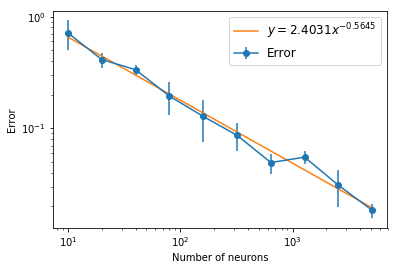

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(10,5120,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(10,5120,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y=2.4031x^{-0.5645}$",'Error'],fontsize='large')

In [176]:
args = dict()
args['xp'] = np.array([[-1,-1], [1,1], [0,0], [-1,1], [1,-1]],dtype=np.float32)
# args['xp'] = np.array([[-1.3,-0.7], [0.5,0.9], [-0.8,0.3], [-0.4,1.6], [1.6,-0.4]],dtype=np.float32)
args['fp'] = np.array([[1.5], [1.5], [0.5], [-0.5], [-0.5]],dtype=np.float32)
# args['fp'] = np.array([1.5, 1.5, 0.5, -0.5, -0.5],dtype=np.float32)
# args['fp'] = np.array([[0.05], [0.02], [0], [-0.01], [-0.03]],dtype=np.float32)
args['input_dim'] = 2
args['tag'] = "2d_toy"
args['train_only_output'] = True
# args['bias'] = ("uniform", 2)
args['bias'] = ("uniform", 2)
args['weight'] = "unit_vector"

numgrid = 21
R = np.abs(args['xp']).max()
x = np.linspace(-R, R, numgrid, dtype=np.float32)
h = x[1]-x[0]
y = np.linspace(-R, R, numgrid, dtype=np.float32)
X, Y = np.meshgrid(x, y)
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=2)

M = args['xp'].shape[0]
d = args['xp'].shape[1]
coeff = np.zeros((M+d+1,M+d+1))
for i in range(M):
    coeff[i,0:M] = np.linalg.norm(args['xp']-args['xp'][i], axis=1)**3
    coeff[i,M:M+d] = args['xp'][i]
    coeff[i,M+d] = 1
    coeff[M:M+d, i] = args['xp'][i]
    coeff[M+d, i] = 1

lambda_u_v = np.linalg.solve(coeff, np.concatenate((args['fp'].squeeze(),np.zeros(3))))

u_first = lambda_u_v[-3:-1]
v_first = lambda_u_v[-1]

fx = x.copy()
fy = y.copy()
f_variation_exact = np.zeros((fx.shape[0], fy.shape[0]))
fX, fY = np.meshgrid(fx, fy)
xi = np.zeros((2))

print("compute f")
for idx, ix in enumerate(fx):
    for idy, iy in enumerate(fy):
        xi[0] = ix
        xi[1] = iy
        f_variation_exact[idy,idx]=np.dot(lambda_u_v, 
                                          np.concatenate((np.linalg.norm(args['xp']-xi, axis=1)**3,xi,np.ones(1))))
        

compute f


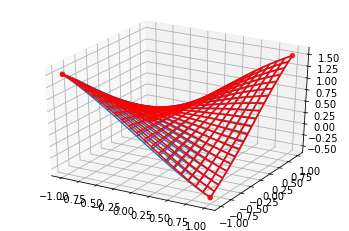

In [146]:
from scipy.interpolate import CubicSpline


num_neurons = 2560
model = TwoLayerReluASI(input_dim=2, num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = '2d_toy'+str(num_neurons)

model_state = torch.load(path+tag+'_best'+"normal [-1,1]")
model.load_state_dict(model_state)

h=0.06
test_input = np.concatenate((X, Y), axis=2)
test_input = test_input.reshape(-1,2)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=numgrid*numgrid, shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
test_output = test_output.reshape(numgrid, numgrid)


%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)
# ax.plot_wireframe(fX[120:-120,120:-120], fY[120:-120,120:-120], f[120:-120,120:-120])
ax.plot_wireframe(fX, fY, f_variation_exact)
ax.plot_wireframe(fX, fY, test_output, color="red")
ax.scatter3D(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), args['fp'].squeeze(), c="red");
plt.show()

Text(0.5, 1.0, 'Exact Solution')

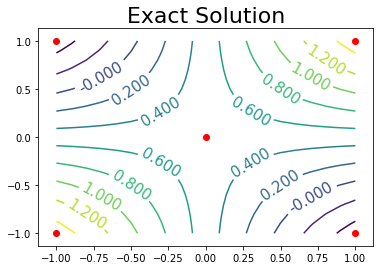

In [142]:
fig, ax = plt.subplots()
CS2 = ax.contour(fX, fY, f_variation_exact, levels=np.linspace(-0.4, 1.4, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("Exact Solution", fontsize=22)

Text(0.5, 1.0, 'n=10')

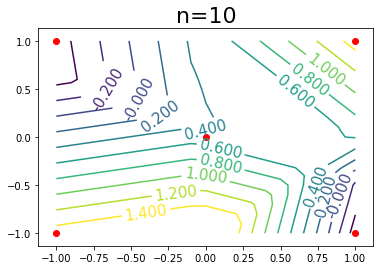

In [143]:
fig, ax = plt.subplots()
# CS = ax.contour(fX, fY, f_variation_exact, 40)
# ax.clabel(CS, inline=True, fontsize=10)
CS2 = ax.contour(fX, fY, test_output, np.linspace(-0.4, 1.4, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=10", fontsize=22)

Text(0.5, 1.0, 'n=160')

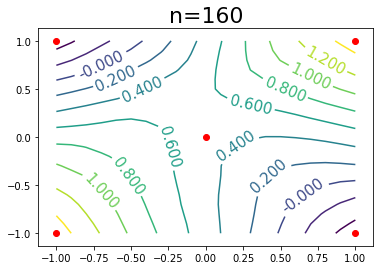

In [145]:
fig, ax = plt.subplots()
# CS = ax.contour(fX, fY, f_variation_exact, 40)
# ax.clabel(CS, inline=True, fontsize=10)
CS2 = ax.contour(fX, fY, test_output, np.linspace(-0.4, 1.4, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=160", fontsize=22)

Text(0.5, 1.0, 'n=2560')

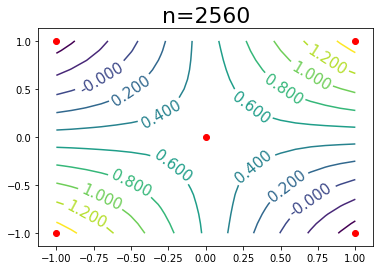

In [147]:
fig, ax = plt.subplots()
# CS = ax.contour(fX, fY, f_variation_exact, 40)
# ax.clabel(CS, inline=True, fontsize=10)
CS2 = ax.contour(fX, fY, test_output, np.linspace(-0.4, 1.4, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=2560", fontsize=22)

In [107]:
#more training data
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560,5120]
y=np.array([51.78746302499977, 83.73414552706348, 6.812198596379804, 2.229533068293261, 2.3807429751925127, 1.7345593106031638, 0.6884635398736716, 0.41529279541234804, 0.1560936108324628, 0.2888259828756666])
error=np.array([430.55660470667044, 7081.022930517875, 9.097453676224717, 0.7610371323022083, 0.5171826818074425, 0.4218159910262096, 0.0745807937403632, 0.008002420921281284, 0.0032202528444841456, 0.007234809885778196])
from sklearn.linear_model import LinearRegression
start = 2
end = len(x)-1
n = np.log(x[start:end]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:end])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:end]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

0.9450487849135816

In [108]:
reg.coef_

array([-0.41039201])

In [109]:
np.exp(reg.intercept_)

11.482164958378345

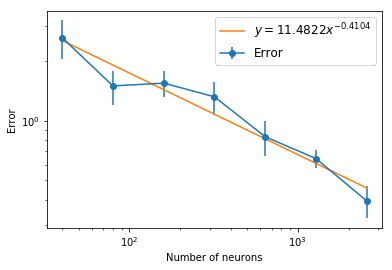

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(40,2560,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(40,2560,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:end], np.sqrt(y[start:end]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:end], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y=11.4822x^{-0.4104}$",'Error'],fontsize='large')

In [150]:
args = dict()
args['xp'] = np.array([[-1,-1], [1,1], [0,0], [-1,1], [1,-1], [-1.3,-0.7], [0.5,0.9], [-0.8,0.3], [-0.4,1.6], [1.6,-0.4]],dtype=np.float32)
args['fp'] = np.array([[1.5], [1.5], [0.5], [-0.5], [-0.5], [-1.5], [-1.5], [-0.5], [0.5], [0.5]],dtype=np.float32)
# args['fp'] = np.array([1.5, 1.5, 0.5, -0.5, -0.5],dtype=np.float32)
# args['fp'] = np.array([[0.05], [0.02], [0], [-0.01], [-0.03]],dtype=np.float32)
args['input_dim'] = 2
args['tag'] = "2d_toy"
args['train_only_output'] = True
# args['bias'] = ("uniform", 2)
args['bias'] = ("uniform", 2)
args['weight'] = "unit_vector"

numgrid = 21
R = np.abs(args['xp']).max()
x = np.linspace(-R, R, numgrid, dtype=np.float32)
h = x[1]-x[0]
y = np.linspace(-R, R, numgrid, dtype=np.float32)
X, Y = np.meshgrid(x, y)
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=2)

M = args['xp'].shape[0]
d = args['xp'].shape[1]
coeff = np.zeros((M+d+1,M+d+1))
for i in range(M):
    coeff[i,0:M] = np.linalg.norm(args['xp']-args['xp'][i], axis=1)**3
    coeff[i,M:M+d] = args['xp'][i]
    coeff[i,M+d] = 1
    coeff[M:M+d, i] = args['xp'][i]
    coeff[M+d, i] = 1

lambda_u_v = np.linalg.solve(coeff, np.concatenate((args['fp'].squeeze(),np.zeros(3))))

u_first = lambda_u_v[-3:-1]
v_first = lambda_u_v[-1]

fx = x.copy()
fy = y.copy()
f_variation_exact = np.zeros((fx.shape[0], fy.shape[0]))
fX, fY = np.meshgrid(fx, fy)
xi = np.zeros((2))

print("compute f")
for idx, ix in enumerate(fx):
    for idy, iy in enumerate(fy):
        xi[0] = ix
        xi[1] = iy
        f_variation_exact[idy,idx]=np.dot(lambda_u_v, 
                                          np.concatenate((np.linalg.norm(args['xp']-xi, axis=1)**3,xi,np.ones(1))))
          

compute f


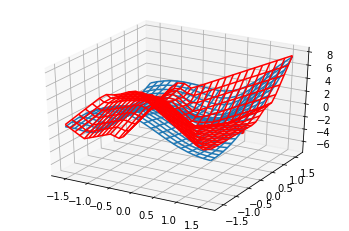

In [151]:
from scipy.interpolate import CubicSpline


num_neurons = 10
model = TwoLayerReluASI(input_dim=2, num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = '2d_toy_complicate_data'+str(num_neurons)

model_state = torch.load(path+tag+'_best'+"normal [-1,1]")
model.load_state_dict(model_state)

h=0.06
test_input = np.concatenate((X, Y), axis=2)
test_input = test_input.reshape(-1,2)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=numgrid*numgrid, shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
test_output = test_output.reshape(numgrid, numgrid)


%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)
# ax.plot_wireframe(fX[120:-120,120:-120], fY[120:-120,120:-120], f[120:-120,120:-120])
ax.plot_wireframe(fX, fY, f_variation_exact)
ax.plot_wireframe(fX, fY, test_output, color="red")
ax.scatter3D(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), args['fp'].squeeze(), c="red");
plt.show()

Text(0.5, 1.0, 'n=10')

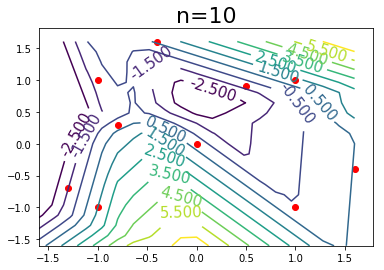

In [152]:
fig, ax = plt.subplots()
# CS = ax.contour(fX, fY, f_variation_exact, 40)
# ax.clabel(CS, inline=True, fontsize=10)
CS2 = ax.contour(fX, fY, test_output, levels=np.linspace(-2.5, 6.5, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=10", fontsize=22)

Text(0.5, 1.0, 'n=160')

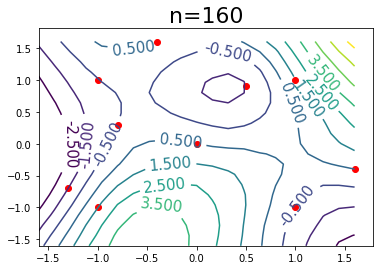

In [136]:
fig, ax = plt.subplots()
# CS = ax.contour(fX, fY, f_variation_exact, 40)
# ax.clabel(CS, inline=True, fontsize=10)
CS2 = ax.contour(fX, fY, test_output, levels=np.linspace(-2.5, 6.5, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=160", fontsize=22)

Text(0.5, 1.0, 'n=2560')

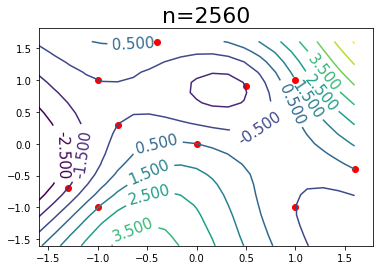

In [138]:
fig, ax = plt.subplots()
# CS = ax.contour(fX, fY, f_variation_exact, 40)
# ax.clabel(CS, inline=True, fontsize=10)
CS2 = ax.contour(fX, fY, test_output, levels=np.linspace(-2.5, 6.5, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=2560", fontsize=22)

Text(0.5, 1.0, 'Exact Solution')

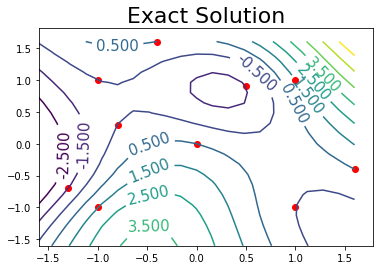

In [132]:
fig, ax = plt.subplots()
CS2 = ax.contour(fX, fY, f_variation_exact, levels=np.linspace(-2.5, 6.5, 10, dtype=np.float32))
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("Exact Solution", fontsize=22)

In [130]:
np.linspace(-3, 6, 10, dtype=np.float32)

array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.], dtype=float32)

In [269]:
# Gaussian distribution
import sys
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import argparse
import matplotlib.pyplot as plt
from networks import *
from normal_train import *
import numpy as np
import copy
import math
# linear correction
from scipy.optimize import LinearConstraint
import math
import numpy as np

# def continuous_version_with_linear(args):
#     # num_angle = 601
#     # angle = np.linspace(0, 2*math.pi, num_angle, dtype=np.float32)
#     # angle = angle[0:-1]
#     # num_bias = 601
#     # bias = np.linspace(-2, 2, num_bias, dtype=np.float32) 

#     # weight = np.ones((angle.shape[0], bias.shape[0]))
#     # weight[0] = 1/2
#     # weight[-1] = 1/2
#     # weight[:,0] = 1/2
#     # weight[:,-1] = 1/2

#     # Angle, Bias = np.meshgrid(angle, bias)
#     # Angle = Angle.reshape(-1)
#     # Bias = Bias.reshape(-1)

#     linear_constraint_weight = np.zeros((args["xp"].shape[0], Angle.shape[0]+3))
#     for idx, train_sample in enumerate(args["xp"]):
#     #     linear_constraint_weight[idx] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
#         linear_constraint_weight[idx,0:-3] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
#         linear_constraint_weight[idx,-3] = train_sample[0]
#         linear_constraint_weight[idx,-2] = train_sample[1]
#         linear_constraint_weight[idx,-1] = 1

#     linear_constraint_with_linear = LinearConstraint(linear_constraint_weight, args["fp"].reshape(-1), args["fp"].reshape(-1))
#     # M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
#     # P = np.dot(M.T, M)  # quick way to build a symmetric matrix
#     # q = np.dot(np.array([3., 2., 3.]), M).reshape((3,))
#     # G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
#     # h = np.array([3., 2., -2.]).reshape((3,))
#     # A = np.array([1., 1., 1.])
#     # b = np.array([1.])

#     # print("QP solution:", solve_qp(P, q, None, None, A, b))

#     from scipy.optimize import minimize
#     def obj_with_linear(x):
#         return np.sum(x[0:-3]**2*weight.reshape(-1))

#     def obj_der_with_linear(x):
#         return np.concatenate((2*x[0:-3],np.array([0,0,0])))


#     def obj_hess_p_with_linear(x, p):
#         return np.concatenate((2*p[0:-3],np.array([0,0,0])))

#     x0 = np.zeros(angle.shape[0]*bias.shape[0]+3)


#     return minimize(obj_with_linear, x0, method='trust-constr', jac=obj_der_with_linear, hessp=obj_hess_p_with_linear,
#                 constraints=[linear_constraint_with_linear],
#                 options={'verbose': 1, 'xtol':1e-20, 'gtol':1e-10})


# no linear correction

def continuous_version(args):
    # num_angle = 601
    # angle = np.linspace(0, 2*math.pi, num_angle, dtype=np.float32)
    # angle = angle[0:-1]
    # num_bias = 601
    # bias = np.linspace(-2, 2, num_bias, dtype=np.float32) 

    # weight = np.ones((angle.shape[0], bias.shape[0]))
    # weight[0] = 1/2
    # weight[-1] = 1/2
    # weight[:,0] = 1/2
    # weight[:,-1] = 1/2

    # Angle, Bias = np.meshgrid(angle, bias)
    # Angle = Angle.reshape(-1)
    # Bias = Bias.reshape(-1)

    linear_constraint_weight = np.zeros((args["xp"].shape[0], Angle.shape[0]))
    # linear_constraint_weight = np.zeros((args["xp"].shape[0], Angle.shape[0]+3))
    for idx, train_sample in enumerate(args["xp"]):
        linear_constraint_weight[idx] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
    #     linear_constraint_weight[idx,0:-3] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
    #     linear_constraint_weight[idx,-3] = train_sample[0]
    #     linear_constraint_weight[idx,-2] = train_sample[1]
    #     linear_constraint_weight[idx,-1] = 1

    linear_constraint = LinearConstraint(linear_constraint_weight, args["fp"].reshape(-1), args["fp"].reshape(-1))
    # M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
    # P = np.dot(M.T, M)  # quick way to build a symmetric matrix
    # q = np.dot(np.array([3., 2., 3.]), M).reshape((3,))
    # G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
    # h = np.array([3., 2., -2.]).reshape((3,))
    # A = np.array([1., 1., 1.])
    # b = np.array([1.])

    # print("QP solution:", solve_qp(P, q, None, None, A, b))

    from scipy.optimize import minimize
    def obj(x):
    #     return np.sum(x[0:-3]**2*weight.reshape(-1))
        return np.sum(x**2*weight.reshape(-1))

    def obj_der(x):
    #     return np.concatenate((2*x[0:-3],np.array([0,0,0])))
        return 2*x


    def obj_hess_p(x, p):
    #     return np.concatenate((2*p[0:-3],np.array([0,0,0])))
        return 2*p

    # x0 = np.zeros(angle.shape[0]*bias.shape[0]+3)
    x0 = np.zeros(angle.shape[0]*bias.shape[0])


    return minimize(obj, x0, method='trust-constr', jac=obj_der, hessp=obj_hess_p,
                    constraints=[linear_constraint],
                    options={'verbose': 1})

def sum_of_all_parameter(model):
    res = 0
    if isinstance(model, TwoLayerReluASI):
        for p in model.features1:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())

        for p in model.features2:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())
    else:
        for p in model.features:
            if p.__class__.__name__=="Linear":
                res+=np.linalg.norm(p.weight.detach().numpy().squeeze())

    return res

def two_relu_layer_train(args, num_neurons=100):
    epochs = 100000
    path = '/home/huijin/seminar project/model/'

    #     tag='sgd_epoch'+str(epochs)+'_init_'+str(initialization)+'_lr_'+str(learning_rate)+'_bs_'+str(batch_size)+'_network_'+network_choice
    tag = args['tag']+str(num_neurons)
    input_dim = args['input_dim']
    
    model = TwoLayerReluASI(input_dim=input_dim, num_neurons=num_neurons, 
                            initialization=args['weight'], bias_tune_tuple=args['bias'])

    global best_acc
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    use_cuda = True
    best_loss = 1000000
    old_loss = 10
    learning_rate = 0.05 #0.02
    #     momentum = 0.9
    #     weight_decay = 5e-4
    # Data
    #     dataloader = datasets.CIFAR10
    #     train_batch = batch_size #128
    #     test_batch = 100
    workers = 1
    decay_epoch = 100000
    use_cuda = False

    #     if accumulation_steps*batch_size/learning_rate>=4096/0.02:
    #         decay_epoch = 250
    #         epochs = 400
    #     elif accumulation_steps*batch_size/learning_rate>=4096/0.04:
    #         decay_epoch = 200
    #         epochs = 350

#     xp = np.array([-2, -1, 0, 1, 2],dtype=np.float)
#     fp = [1.5, 0.5, 1.5, 0.5, 1.5]
    xp = args['xp']
    fp = args['fp']
    # train_input = np.sort(np.concatenate((np.random.uniform(-2,2,30),xp))).astype(np.float32)
#     train_input = np.sort(xp).astype(np.float32)
#     train_output = np.interp(train_input, xp, fp).astype(np.float32)
    train_input = xp
    train_output = fp

    trainset = [(train_input[i:i+1], train_output[i:i+1]) for i in range(train_input.shape[0])]
    # batch_size=train_input.shape[0]
    trainloader = data.DataLoader(trainset, batch_size=train_input.shape[0], shuffle=False, num_workers=workers)

    #     testset = dataloader(root='/home/huijin/large-batch-training-torch/data', train=False, download=False, transform=transform_test)
    #     testloader = data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=workers)

    #     model = AlexNet(10)
    #     model_state = torch.load('model_38')
    #     model.load_state_dict(model_state)

    criterion = nn.MSELoss()
    #     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay= weight_decay)
    if args['train_only_output']:
        model.features1[0].weight.requires_grad = False
        model.features1[0].bias.requires_grad = False
        model.features2[0].weight.requires_grad = False
        model.features2[0].bias.requires_grad = False

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    if use_cuda == True:
        model = model.cuda()
        criterion = criterion.cuda()

    # Initialization

    #     initial_model_file = '/home/huijin/large-batch-training-torch/model/init_'+str(initialization)+'_network_'+network_choice
    #     if os.path.isfile(initial_model_file):
    #         model_state = torch.load(initial_model_file)
    #         model.load_state_dict(model_state)
    #     else:
    #         torch.save(model.state_dict(), initial_model_file)
    inital_norm_weight = sum_of_all_parameter(model)
    # Train and val
    history = dict(loss=list(),val_loss=list(),acc=list(),val_acc=list())
    old_loss = test(trainloader, model, criterion, 0, use_cuda)+0.01
    for epoch in range(start_epoch, epochs):
#         import ipdb; ipdb.set_trace() 
        old_state_dict = copy.deepcopy(model.state_dict())
#         print(old_state_dict)
#         import ipdb; ipdb.set_trace()
        train_loss = train(trainloader, model, criterion, optimizer, epoch, use_cuda)
    #         test_loss, test_acc = test(testloader, model, criterion, epoch, use_cuda)
        train_loss = test(trainloader, model, criterion, epoch, use_cuda)
        print('Epoch: [%d | %d] LR: %f; Train Loss %f'
              % (epoch + 1, epochs, optimizer.param_groups[0]['lr'],train_loss))
        sys.stdout.flush()
        history['loss'].append(train_loss)

        # save model
        is_best = train_loss < best_loss
        best_loss = min(train_loss, best_loss)
        if is_best:
            torch.save(model.state_dict(), path+tag+'_best'+"normal [-1,1]")
        # torch.save(model.state_dict(), '/home/huijin/large-batch-training-torch/model/'+tag+'model_batch_'+str(epoch+1))

        if train_loss > old_loss:
            model.load_state_dict(old_state_dict)
            learning_rate = learning_rate*0.5
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] *= 1.0/2
        else:
            if epoch % decay_epoch == (decay_epoch-1):
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.5
            if abs(old_loss-train_loss)<1e-8:
                break
            old_loss = train_loss

    torch.save(model.state_dict(), path+tag)
    
    end_norm_weight = sum_of_all_parameter(model)
    
#     test_input = np.arange(-2 , 2 , 0.01).astype(np.float32)
#     testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
#     testloader = data.DataLoader(testset, batch_size=test_input.shape[0], shuffle=False, num_workers=workers)
#     for batch_idx, inputs in enumerate(testloader):
#         outputs = model(inputs)
#     test_output = outputs.squeeze().detach().numpy()
#     true_output = np.interp(test_input, xp, fp)
#     away_from_piecewise_linear = np.mean((true_output-test_output)**2)
    return (inital_norm_weight, end_norm_weight, 0, train_loss, model)

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.square_sum = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.square_sum += val * val * n
        self.count += n
        self.avg = self.sum / self.count
        self.std = self.square_sum / self.count - self.avg*self.avg

args = dict()
args['xp'] = np.array([[-1,-1], [1,1], [0,0], [-1,1], [1,-1]],dtype=np.float32)
# args['xp'] = np.array([[-1.3,-0.7], [0.5,0.9], [-0.8,0.3], [-0.4,1.6], [1.6,-0.4]],dtype=np.float32)
args['fp'] = np.array([[1.5], [1.5], [0.5], [-0.5], [-0.5]],dtype=np.float32)
# args['fp'] = np.array([1.5, 1.5, 0.5, -0.5, -0.5],dtype=np.float32)
# args['fp'] = np.array([[0.05], [0.02], [0], [-0.01], [-0.03]],dtype=np.float32)
args['input_dim'] = 2
args['tag'] = "2d_toy_gaussian_try"
args['train_only_output'] = True
# args['bias'] = ("uniform", 2)
sigmab = 0.1
args['bias'] = ("normal", sigmab)
args['weight'] = "normal"
sigmaw = 1

numgrid = 21
R = np.abs(args['xp']).max()
x = np.linspace(-R, R, numgrid, dtype=np.float32)
h = x[1]-x[0]
y = np.linspace(-R, R, numgrid, dtype=np.float32)
X, Y = np.meshgrid(x, y)
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=2)

# M = args['xp'].shape[0]
# d = args['xp'].shape[1]
# coeff = np.zeros((M+d+1,M+d+1))
# for i in range(M):
#     coeff[i,0:M] = np.linalg.norm(args['xp']-args['xp'][i], axis=1)**3
#     coeff[i,M:M+d] = args['xp'][i]
#     coeff[i,M+d] = 1
#     coeff[M:M+d, i] = args['xp'][i]
#     coeff[M+d, i] = 1

# lambda_u_v = np.linalg.solve(coeff, np.concatenate((args['fp'].squeeze(),np.zeros(3))))

# u_first = lambda_u_v[-3:-1]
# v_first = lambda_u_v[-1]

# fx = x.copy()
# fy = y.copy()
# f_variation_exact = np.zeros((fx.shape[0], fy.shape[0]))
# fX, fY = np.meshgrid(fx, fy)
# xi = np.zeros((2))

# print("compute f")
# for idx, ix in enumerate(fx):
#     for idy, iy in enumerate(fy):
#         xi[0] = ix
#         xi[1] = iy
#         f_variation_exact[idy,idx]=np.dot(lambda_u_v, 
#                                           np.concatenate((np.linalg.norm(args['xp']-xi, axis=1)**3,xi,np.ones(1))))

num_angle = 601
angle = np.linspace(0, 2*math.pi, num_angle, dtype=np.float32)
angle = angle[0:-1]
num_bias = 601
bias = np.linspace(-2, 2, num_bias, dtype=np.float32) 

weight = np.ones((angle.shape[0], bias.shape[0]))
weight[0] = 1/2
weight[-1] = 1/2
weight[:,0] = 1/2
weight[:,-1] = 1/2
weight = weight/(sigmab*sigmab+bias*bias*sigmaw*sigmaw)**2.5
weight = weight.T

Angle, Bias = np.meshgrid(angle, bias)
Angle = Angle.reshape(-1)
Bias = Bias.reshape(-1)
# res_with_linear = continuous_version_with_linear(args)
res_non_linear = continuous_version(args)
fx = x.copy()
fy = y.copy()
# f_variation_linear_adjust = np.zeros((fx.shape[0], fy.shape[0]))
f_variation_no_linear_adjust = np.zeros((fx.shape[0], fy.shape[0]))
fX, fY = np.meshgrid(fx, fy)
xi = np.zeros((2))

print("compute f")
# for idx, ix in enumerate(fx):
#     for idy, iy in enumerate(fy):
#         xi[0] = ix
#         xi[1] = iy
#         first_layer = np.maximum(np.cos(Angle)*ix+np.sin(Angle)*iy+Bias,0)*weight.reshape(-1)
#         f_variation_linear_adjust[idy,idx]=np.sum(first_layer*res_with_linear.x[0:-3])+\
#             res_with_linear.x[-3]*ix+res_with_linear.x[-2]*iy+res_with_linear.x[-1]
for idx, ix in enumerate(fx):
    for idy, iy in enumerate(fy):
        xi[0] = ix
        xi[1] = iy
        first_layer = np.maximum(np.cos(Angle)*ix+np.sin(Angle)*iy+Bias,0)*weight.reshape(-1)
        f_variation_no_linear_adjust[idy,idx]=np.sum(first_layer*res_non_linear.x)


nums_of_neurons=[5120, 10240, 20480]
# nums_of_neurons=[20]

inital_norm_weight_vs_num = []
inital_norm_weight_std_vs_num = []
end_norm_weight_vs_num = []
end_norm_weight_std_vs_num = []
away_from_variational_vs_num = []
away_from_variational_std_vs_num = []
train_loss_vs_num = []
train_loss_std_vs_num = []

for num_of_neurons in nums_of_neurons:
    number_of_try = 1
    inital_norm_weights = AverageMeter()
    end_norm_weights = AverageMeter()
    away_from_variationals = AverageMeter()
    train_losses = AverageMeter()
    for init in range(number_of_try):
        inital_norm_weight, end_norm_weight, away_from_variational, train_loss, model = two_relu_layer_train(args, num_of_neurons)
        test_input = np.concatenate((X, Y), axis=2)
        test_input = test_input.reshape(-1,2)
        testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
        testloader = data.DataLoader(testset, batch_size=numgrid*numgrid, shuffle=False, num_workers=1)
        for batch_idx, inputs in enumerate(testloader):
            outputs = model(inputs)
        test_output = outputs.squeeze().detach().numpy()
        test_output = test_output.reshape(numgrid, numgrid)
#         away_from_variational = np.sum((test_output - f_variation_linear_adjust)**2)*h*h
        away_from_variational = np.sum((test_output - f_variation_no_linear_adjust)**2)*h*h
        print()
        inital_norm_weights.update(inital_norm_weight)
        end_norm_weights.update(end_norm_weight)
        away_from_variationals.update(away_from_variational)
        train_losses.update(train_loss)

    inital_norm_weight_vs_num.append(inital_norm_weights.avg)
    end_norm_weight_vs_num.append(end_norm_weights.avg)
    away_from_variational_vs_num.append(away_from_variationals.avg)

    inital_norm_weight_std_vs_num.append(inital_norm_weights.std)
    end_norm_weight_std_vs_num.append(end_norm_weights.std)
    away_from_variational_std_vs_num.append(away_from_variationals.std)

    train_loss_vs_num.append(train_losses.avg)
    train_loss_std_vs_num.append(train_losses.std)

print(inital_norm_weight_vs_num)
print(end_norm_weight_vs_num)
print(away_from_variational_vs_num)
print(train_loss_vs_num)

print(inital_norm_weight_std_vs_num)
print(end_norm_weight_std_vs_num)
print(away_from_variational_std_vs_num)
print(train_loss_std_vs_num)


`gtol` termination condition is satisfied.
Number of iterations: 2, function evaluations: 2, CG iterations: 0, optimality: 6.06e-21, constraint violation: 1.22e-15, execution time: 0.17 s.
compute f
bias_tune normal success
Epoch: [1 | 100000] LR: 0.050000; Train Loss 7017.264160
Epoch: [2 | 100000] LR: 0.025000; Train Loss 1722.612549
Epoch: [3 | 100000] LR: 0.012500; Train Loss 415.195007
Epoch: [4 | 100000] LR: 0.006250; Train Loss 96.463463
Epoch: [5 | 100000] LR: 0.003125; Train Loss 20.841972
Epoch: [6 | 100000] LR: 0.001563; Train Loss 3.967295
Epoch: [7 | 100000] LR: 0.000781; Train Loss 0.763975
Epoch: [8 | 100000] LR: 0.000781; Train Loss 1.745159
Epoch: [9 | 100000] LR: 0.000391; Train Loss 0.183235
Epoch: [10 | 100000] LR: 0.000391; Train Loss 0.085906


KeyboardInterrupt: 

In [157]:
f_variation_no_linear_adjust

array([[ 1.50000000e+00,  1.43260653e+00,  1.35719588e+00,
         1.27333365e+00,  1.18078335e+00,  1.07957902e+00,
         9.70121951e-01,  8.53258051e-01,  7.30320777e-01,
         6.03120206e-01,  4.73859667e-01,  3.44975359e-01,
         2.18921361e-01,  9.79825569e-02, -1.58960317e-02,
        -1.21222567e-01, -2.17002774e-01, -3.02720995e-01,
        -3.78275320e-01, -4.43882934e-01, -5.00000000e-01],
       [ 1.43253235e+00,  1.37263992e+00,  1.30483917e+00,
         1.22849923e+00,  1.14321725e+00,  1.04887171e+00,
         9.45728925e-01,  8.34550227e-01,  7.16663481e-01,
         5.93970727e-01,  4.68862690e-01,  3.44032810e-01,
         2.22215080e-01,  1.05942529e-01, -2.66651675e-03,
        -1.02046428e-01, -1.91224910e-01, -2.69783442e-01,
        -3.37762689e-01, -3.95551996e-01, -4.43839342e-01],
       [ 1.35705806e+00,  1.30477542e+00,  1.24510409e+00,
         1.17706939e+00,  1.10002400e+00,  1.01364708e+00,
         9.18026971e-01,  8.13790951e-01,  7.02211391e

Text(0.5, 1.0, 'Exact Solution')

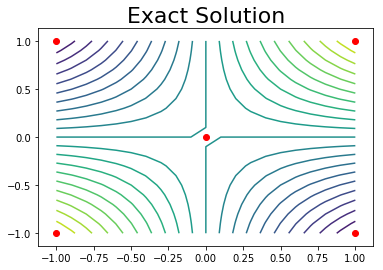

In [249]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, f_variation_exact, levels=20)
# ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("Exact Solution", fontsize=22)

Text(0.5, 1.0, 'Exact Solution')

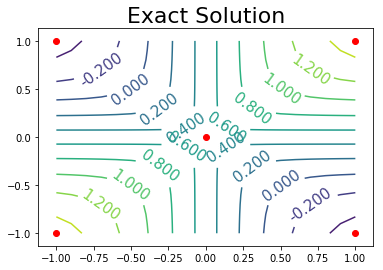

In [294]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, f_variation_linear_adjust, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("Exact Solution", fontsize=22)

Text(0.5, 1.0, 'n=10')

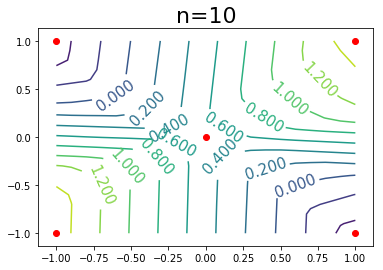

In [298]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, test_output, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=10", fontsize=22)

Text(0.5, 1.0, 'n=160')

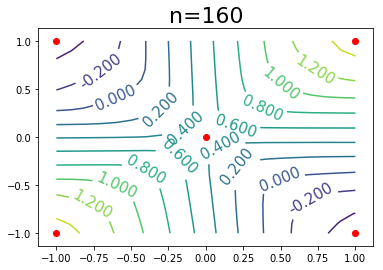

In [296]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, test_output, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=160", fontsize=22)

Text(0.5, 1.0, 'n=2560')

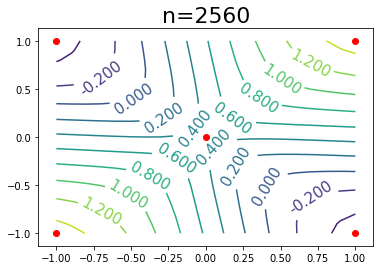

In [292]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, test_output, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=2560", fontsize=22)

[-0.12346555] 0.26674261891458423


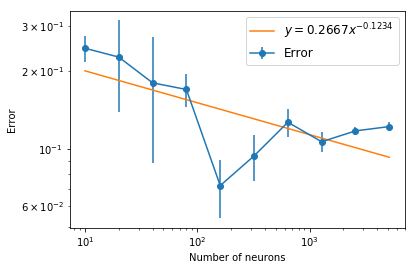

In [6]:
#Gaussian
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560,5120]
y=np.array([0.060287432518277416, 0.051478901047037, 0.0325407403096205, 0.02889898372245756, 0.005215834804689428, 0.008845463667322565, 0.016118985035728464, 0.011387311342156656, 0.013824753452600409, 0.014924346350403225])
error=np.array([0.00019879209209166778, 0.0015810328202742405, 0.0011046609003449808, 6.894614267375883e-05, 6.8983273993002e-06, 1.2778487721475313e-05, 1.5635011729051007e-05, 3.919142182289611e-06, 1.0040052916895643e-06, 1.3310643453791544e-06])
from sklearn.linear_model import LinearRegression
start = 0
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)
print(reg.coef_,np.exp(reg.intercept_))
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(10,5120,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(10,5120,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y=0.2667x^{-0.1234}$",'Error'],fontsize='large')

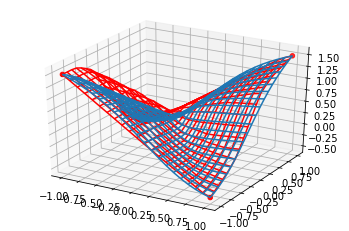

In [297]:
from scipy.interpolate import CubicSpline


num_neurons = 10
model = TwoLayerReluASI(input_dim=2, num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = '2d_toy_gaussian01'+str(num_neurons)

model_state = torch.load(path+tag+'_best'+"normal [-1,1]")
model.load_state_dict(model_state)

# h=0.06
test_input = np.concatenate((X, Y), axis=2)
test_input = test_input.reshape(-1,2)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=numgrid*numgrid, shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
test_output = test_output.reshape(numgrid, numgrid)


%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)
# ax.plot_wireframe(fX[120:-120,120:-120], fY[120:-120,120:-120], f[120:-120,120:-120])
ax.plot_wireframe(fX, fY, f_variation_no_linear_adjust)
# ax.plot_wireframe(fX, fY, f_variation_exact, color="red")
ax.plot_wireframe(fX, fY, test_output, color="red")
ax.scatter3D(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), args['fp'].squeeze(), c="red");
plt.show()

In [268]:
sigmab = 0.1
def continuous_version_with_linear(args):
    # num_angle = 601
    # angle = np.linspace(0, 2*math.pi, num_angle, dtype=np.float32)
    # angle = angle[0:-1]
    # num_bias = 601
    # bias = np.linspace(-2, 2, num_bias, dtype=np.float32) 

    # weight = np.ones((angle.shape[0], bias.shape[0]))
    # weight[0] = 1/2
    # weight[-1] = 1/2
    # weight[:,0] = 1/2
    # weight[:,-1] = 1/2

    # Angle, Bias = np.meshgrid(angle, bias)
    # Angle = Angle.reshape(-1)
    # Bias = Bias.reshape(-1)

    linear_constraint_weight = np.zeros((args["xp"].shape[0], Angle.shape[0]+3))
    for idx, train_sample in enumerate(args["xp"]):
    #     linear_constraint_weight[idx] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
        linear_constraint_weight[idx,0:-3] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
        linear_constraint_weight[idx,-3] = train_sample[0]
        linear_constraint_weight[idx,-2] = train_sample[1]
        linear_constraint_weight[idx,-1] = 1

    linear_constraint_with_linear = LinearConstraint(linear_constraint_weight, args["fp"].reshape(-1), args["fp"].reshape(-1))
    # M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
    # P = np.dot(M.T, M)  # quick way to build a symmetric matrix
    # q = np.dot(np.array([3., 2., 3.]), M).reshape((3,))
    # G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
    # h = np.array([3., 2., -2.]).reshape((3,))
    # A = np.array([1., 1., 1.])
    # b = np.array([1.])

    # print("QP solution:", solve_qp(P, q, None, None, A, b))

    from scipy.optimize import minimize
    def obj_with_linear(x):
        return np.sum(x[0:-3]**2*weight.reshape(-1))

    def obj_der_with_linear(x):
        return np.concatenate((2*x[0:-3],np.array([0,0,0])))


    def obj_hess_p_with_linear(x, p):
        return np.concatenate((2*p[0:-3],np.array([0,0,0])))

    x0 = np.zeros(angle.shape[0]*bias.shape[0]+3)


    return minimize(obj_with_linear, x0, method='trust-constr', jac=obj_der_with_linear, hessp=obj_hess_p_with_linear,
                constraints=[linear_constraint_with_linear],
                options={'verbose': 1, 'xtol':1e-20, 'gtol':1e-10})
                    
num_angle = 601
angle = np.linspace(0, 2*math.pi, num_angle, dtype=np.float32)
angle = angle[0:-1]
num_bias = 601
bias = np.linspace(-2, 2, num_bias, dtype=np.float32) 

weight = np.ones((angle.shape[0], bias.shape[0]))
weight[0] = 1/2
weight[-1] = 1/2
weight[:,0] = 1/2
weight[:,-1] = 1/2
weight = weight/(sigmab*sigmab+bias*bias*sigmaw*sigmaw)**2.5
weight = weight.T

Angle, Bias = np.meshgrid(angle, bias)
Angle = Angle.reshape(-1)
Bias = Bias.reshape(-1)
res_with_linear = continuous_version_with_linear(args)
fx = x.copy()
fy = y.copy()
f_variation_linear_adjust = np.zeros((fx.shape[0], fy.shape[0]))
fX, fY = np.meshgrid(fx, fy)
xi = np.zeros((2))

print("compute f")
for idx, ix in enumerate(fx):
    for idy, iy in enumerate(fy):
        xi[0] = ix
        xi[1] = iy
        first_layer = np.maximum(np.cos(Angle)*ix+np.sin(Angle)*iy+Bias,0)*weight.reshape(-1)
        f_variation_linear_adjust[idy,idx]=np.sum(first_layer*res_with_linear.x[0:-3])+\
            res_with_linear.x[-3]*ix+res_with_linear.x[-2]*iy+res_with_linear.x[-1]

`gtol` termination condition is satisfied.
Number of iterations: 2, function evaluations: 2, CG iterations: 2, optimality: 1.46e-17, constraint violation: 1.55e-15, execution time: 0.23 s.
compute f


In [207]:
h = x[1]-x[0]

In [228]:
np.sum((f_variation_exact - f_variation_linear_adjust)**2)*h*h

0.055281467162805104

In [270]:
np.sum((f_variation_linear_adjust - f_variation_no_linear_adjust)**2)*h*h/(np.sum((f_variation_no_linear_adjust)**2)*h*h)

0.005508671903082272

In [229]:
np.sum((test_output - f_variation_linear_adjust)**2)*h*h

0.023849406677319836

In [230]:
np.sum((test_output - f_variation_no_linear_adjust)**2)*h*h

0.03195100653355606

In [265]:
(np.sum((f_variation_no_linear_adjust)**2)*h*h)

1.9919593124895343

### Gaussian N(0,1)

In [15]:
from scipy.interpolate import CubicSpline

args = dict()
args['xp'] = np.array([[-1,-1], [1,1], [0,0], [-1,1], [1,-1]],dtype=np.float32)
# args['xp'] = np.array([[-1.3,-0.7], [0.5,0.9], [-0.8,0.3], [-0.4,1.6], [1.6,-0.4]],dtype=np.float32)
args['fp'] = np.array([[1.5], [1.5], [0.5], [-0.5], [-0.5]],dtype=np.float32)
# args['fp'] = np.array([1.5, 1.5, 0.5, -0.5, -0.5],dtype=np.float32)
# args['fp'] = np.array([[0.05], [0.02], [0], [-0.01], [-0.03]],dtype=np.float32)
args['input_dim'] = 2
args['tag'] = "2d_toy"
args['train_only_output'] = True
# args['bias'] = ("uniform", 2)
args['bias'] = ("uniform", 2)
args['weight'] = "unit_vector"
numgrid = 21
R = np.abs(args['xp']).max()
x = np.linspace(-R, R, numgrid, dtype=np.float32)
h = x[1]-x[0]
y = np.linspace(-R, R, numgrid, dtype=np.float32)
X, Y = np.meshgrid(x, y)
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=2)

num_neurons = 2560
model = TwoLayerReluASI(input_dim=2, num_neurons=num_neurons)
path = '/home/huijin/seminar project/model/'
tag = '2d_toy_gaussian'+str(num_neurons)

model_state = torch.load(path+tag+'_best'+"normal [-1,1]")
model.load_state_dict(model_state)

# h=0.06
test_input = np.concatenate((X, Y), axis=2)
test_input = test_input.reshape(-1,2)
testset = [(test_input[i:i+1]) for i in range(test_input.shape[0])]
testloader = data.DataLoader(testset, batch_size=numgrid*numgrid, shuffle=False, num_workers=1)
for batch_idx, inputs in enumerate(testloader):
    outputs = model(inputs)
test_output = outputs.squeeze().detach().numpy()
test_output = test_output.reshape(numgrid, numgrid)


# %matplotlib inline
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # X, Y, Z = axes3d.get_test_data(0.05)
# # ax.plot_wireframe(fX[120:-120,120:-120], fY[120:-120,120:-120], f[120:-120,120:-120])
# ax.plot_wireframe(fX, fY, f_variation_no_linear_adjust)
# # ax.plot_wireframe(fX, fY, f_variation_exact, color="red")
# ax.plot_wireframe(fX, fY, test_output, color="red")
# ax.scatter3D(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), args['fp'].squeeze(), c="red");
# plt.show()

In [10]:
sigmab = 1
sigmaw = 1
from scipy.optimize import LinearConstraint
def continuous_version_with_linear(args):
    # num_angle = 601
    # angle = np.linspace(0, 2*math.pi, num_angle, dtype=np.float32)
    # angle = angle[0:-1]
    # num_bias = 601
    # bias = np.linspace(-2, 2, num_bias, dtype=np.float32) 

    # weight = np.ones((angle.shape[0], bias.shape[0]))
    # weight[0] = 1/2
    # weight[-1] = 1/2
    # weight[:,0] = 1/2
    # weight[:,-1] = 1/2

    # Angle, Bias = np.meshgrid(angle, bias)
    # Angle = Angle.reshape(-1)
    # Bias = Bias.reshape(-1)

    linear_constraint_weight = np.zeros((args["xp"].shape[0], Angle.shape[0]+3))
    for idx, train_sample in enumerate(args["xp"]):
    #     linear_constraint_weight[idx] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
        linear_constraint_weight[idx,0:-3] = np.maximum(np.cos(Angle)*train_sample[0]+np.sin(Angle)*train_sample[1]+Bias,0)*weight.reshape(-1)
        linear_constraint_weight[idx,-3] = train_sample[0]
        linear_constraint_weight[idx,-2] = train_sample[1]
        linear_constraint_weight[idx,-1] = 1

    linear_constraint_with_linear = LinearConstraint(linear_constraint_weight, args["fp"].reshape(-1), args["fp"].reshape(-1))
    # M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
    # P = np.dot(M.T, M)  # quick way to build a symmetric matrix
    # q = np.dot(np.array([3., 2., 3.]), M).reshape((3,))
    # G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
    # h = np.array([3., 2., -2.]).reshape((3,))
    # A = np.array([1., 1., 1.])
    # b = np.array([1.])

    # print("QP solution:", solve_qp(P, q, None, None, A, b))

    from scipy.optimize import minimize
    def obj_with_linear(x):
        return np.sum(x[0:-3]**2*weight.reshape(-1))

    def obj_der_with_linear(x):
        return np.concatenate((2*x[0:-3],np.array([0,0,0])))


    def obj_hess_p_with_linear(x, p):
        return np.concatenate((2*p[0:-3],np.array([0,0,0])))

    x0 = np.zeros(angle.shape[0]*bias.shape[0]+3)


    return minimize(obj_with_linear, x0, method='trust-constr', jac=obj_der_with_linear, hessp=obj_hess_p_with_linear,
                constraints=[linear_constraint_with_linear],
                options={'verbose': 1, 'xtol':1e-20, 'gtol':1e-10})
                    
num_angle = 601
angle = np.linspace(0, 2*math.pi, num_angle, dtype=np.float32)
angle = angle[0:-1]
num_bias = 601
bias = np.linspace(-2, 2, num_bias, dtype=np.float32) 

weight = np.ones((angle.shape[0], bias.shape[0]))
weight[0] = 1/2
weight[-1] = 1/2
weight[:,0] = 1/2
weight[:,-1] = 1/2
weight = weight/(sigmab*sigmab+bias*bias*sigmaw*sigmaw)**2.5
weight = weight.T

Angle, Bias = np.meshgrid(angle, bias)
Angle = Angle.reshape(-1)
Bias = Bias.reshape(-1)
res_with_linear = continuous_version_with_linear(args)
fx = x.copy()
fy = y.copy()
f_variation_linear_adjust = np.zeros((fx.shape[0], fy.shape[0]))
fX, fY = np.meshgrid(fx, fy)
xi = np.zeros((2))

print("compute f")
for idx, ix in enumerate(fx):
    for idy, iy in enumerate(fy):
        xi[0] = ix
        xi[1] = iy
        first_layer = np.maximum(np.cos(Angle)*ix+np.sin(Angle)*iy+Bias,0)*weight.reshape(-1)
        f_variation_linear_adjust[idy,idx]=np.sum(first_layer*res_with_linear.x[0:-3])+\
            res_with_linear.x[-3]*ix+res_with_linear.x[-2]*iy+res_with_linear.x[-1]

`xtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 67, CG iterations: 38, optimality: 4.24e-09, constraint violation: 5.55e-17, execution time:  6.5 s.
compute f


Text(0.5, 1.0, 'Exact Solution')

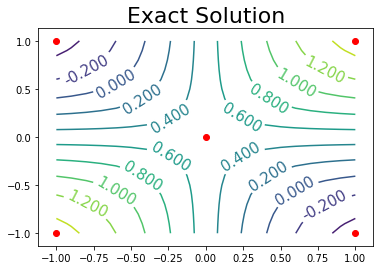

In [17]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, f_variation_linear_adjust, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("Exact Solution", fontsize=22)

Text(0.5, 1.0, 'n=10')

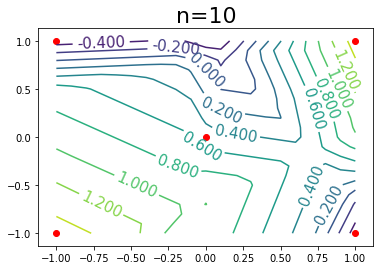

In [11]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, test_output, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=10", fontsize=22)

Text(0.5, 1.0, 'n=160')

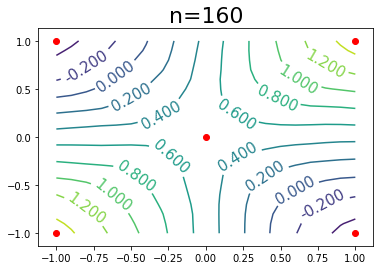

In [14]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, test_output, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=160", fontsize=22)

Text(0.5, 1.0, 'n=2560')

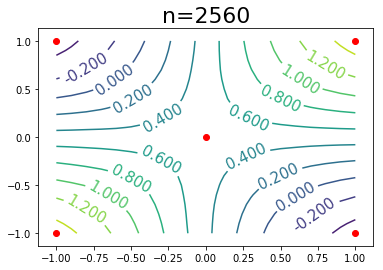

In [16]:
fig, ax = plt.subplots()
# CS2 = ax.contour(fX, fY, f_variation_no_linear_adjust, levels=np.linspace(-0.5, 1.3, 10, dtype=np.float32))
CS2 = ax.contour(fX, fY, test_output, levels=10)
ax.clabel(CS2, inline=True, fontsize=15)
ax.scatter(args['xp'][:,0].squeeze(), args['xp'][:,1].squeeze(), c="red");
plt.title("n=2560", fontsize=22)

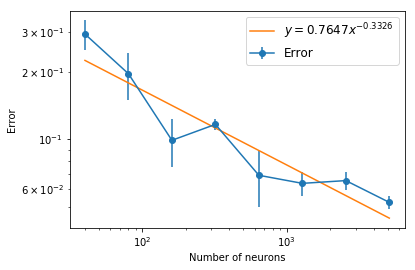

In [18]:
#large linear
import numpy as np
x=[10,20,40,80,160,320,640,1280,2560,5120]
y=np.array([0.40701307908227974, 0.144217191248576, 0.08619928088048444, 0.03828804491203137, 0.00980291494398817, 0.01357869543667385, 0.004791759641084573, 0.004062891584250376, 0.004298237014009901, 0.0027532236664385558])
error=np.array([0.0476044728867831, 0.0067796310320203425, 0.0006643042741588737, 0.00032427489916731053, 2.2435529479782323e-05, 2.3573818939841057e-06, 7.064939915788798e-06, 9.679077324101793e-07, 6.553523640791782e-07, 1.312325663330689e-07])
from sklearn.linear_model import LinearRegression
start = 2
n = np.log(x[start:]).shape[0]
X = np.zeros((n,1))
X[:,0] = np.log(x[start:])
# X[:,1] = np.ones(n)
y_s = np.log(np.sqrt(y[start:]))
reg = LinearRegression().fit(X, y_s)
reg.score(X, y_s)

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax0= plt.subplots()
# ax0.errorbar(x[1:], np.sqrt(y[1:]), yerr=np.sqrt(error[1:])/np.sqrt(y[1:])/2, fmt='-o')
# ax0.loglog(x[start:], np.sqrt(y[start:]), '-o')
plt.xlabel("Number of neurons")
plt.ylabel("Error")
n_line = np.linspace(40,5120,1000).shape[0]
X_line = np.zeros((n_line,1))
X_line[:,0] = np.linspace(40,5120,1000)
ax0.set_xscale("log", nonposx='clip')
ax0.set_yscale("log", nonposy='clip')
# ax4.set(title='Errorbars go negative')
ax0.errorbar(x[start:], np.sqrt(y[start:]), yerr=(np.sqrt(error)/np.sqrt(y)/2)[start:], fmt='-o')
ax0.loglog(X_line[:,0], np.exp(reg.predict(np.log(X_line))))
ax0.legend(["$y="+"{:.4f}".format(np.exp(reg.intercept_))+"x^{"+"{:.4f}".format(reg.coef_.squeeze())+"}$",'Error'],fontsize='large')